## Data

Necessary imports

In [46]:
# Needed to load and preprocess the data  
import pandas as pd
import numpy as np

# Some sklearn tools for preprocessing and building a pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA


# model
from xgboost.sklearn import XGBClassifier

# Used for the analysis part
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer

Loadind and scaling data

In [2]:
# Aquest notebook té 25GB

import pandas as pd
from sklearn.preprocessing import StandardScaler
#from google.colab import files

# data_to_load = files.upload() # use to upload data otherwise just upload through 'files'
data = pd.read_csv("data/train.csv")
sc = StandardScaler()
data.drop(["Id", "BUTTER"], axis=1, inplace=True)

scaled = sc.fit_transform(data.iloc[:, :-1].values)
print(scaled.shape)
X = pd.DataFrame(data=scaled, columns=data.columns[:-1])
y = data.iloc[:, -1] 

X.head()

(212662, 14)


,B_OWNPV_CHI2,B_IPCHI2_OWNPV,B_FDCHI2_OWNPV,B_DIRA_OWNPV,B_PT,Kst_892_0_IP_OWNPV,Kst_892_0_cosThetaH,Kplus_IP_OWNPV,Kplus_P,piminus_IP_OWNPV,piminus_P,gamma_PT,piminus_ETA,Kplus_ETA
0,-0.132425,-0.076019,-0.020581,0.506625,2.457603,-0.010281,-1.635157,-0.000083,1.928913,0.092874,-0.567258,0.808782,-1.001080,-0.923161
1,0.215444,-1.235330,-0.192592,0.509224,-0.657723,-0.778374,-1.718573,-0.693486,0.495555,-0.968792,-0.734406,-0.702845,0.273690,-0.153645
2,0.337583,-0.175317,-0.199826,0.352163,-0.380149,-0.841548,0.066418,-0.833509,-0.103088,-0.749528,0.028360,-0.390404,0.544726,-0.085062
3,-1.080441,1.581900,-0.200571,-2.294296,-0.630449,-0.542046,0.772930,-0.627198,-0.995229,-0.421995,-0.747170,-0.925969,-1.647432,-1.832618
4,1.920171,2.166203,-0.208622,-0.839829,-0.926588,-0.884865,0.904880,-0.879123,-0.932438,-0.807563,0.141575,-0.657284,0.269023,0.218319


In [3]:
features = data.columns[:-1]
features = [feat.strip() for feat in features]
print(len(features))
features

14


['B_OWNPV_CHI2',
 'B_IPCHI2_OWNPV',
 'B_FDCHI2_OWNPV',
 'B_DIRA_OWNPV',
 'B_PT',
 'Kst_892_0_IP_OWNPV',
 'Kst_892_0_cosThetaH',
 'Kplus_IP_OWNPV',
 'Kplus_P',
 'piminus_IP_OWNPV',
 'piminus_P',
 'gamma_PT',
 'piminus_ETA',
 'Kplus_ETA']

In [4]:
# saving feature names for use in the spreadsheet
import csv

with open("features.csv", 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(features)

## The model: XGBoost

### Baseline (no feature engineering nor PCA)

In [5]:
# XGBoost
xgb_model = Pipeline([ # Add a scale_pos_weight to make it balanced
                      ("model", XGBClassifier(scale_pos_weight=(1 - y.mean()), n_jobs=-1))])

In [6]:
# fix random seed for comparisons
# using stratify to have the same proportion of each y value in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.3, random_state=42)

Fitting the model. We do a grid search first in order to have a good enough baseline for feature engineering to work.

In [7]:
gs = GridSearchCV(xgb_model, {"model__max_depth": [5, 10],
                              "model__min_child_weight": [5, 10],
                              "model__n_estimators": [25]},
                  n_jobs=-1, cv=5, scoring="accuracy")

gs.fit(X_train, y_train)

/home/bambusito/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:49:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      min_child_weight=None,
                        

Best params and score

In [8]:
print(gs.best_params_)
print(gs.best_score_)
xgb_model.set_params(**gs.best_params_)
xgb_model.fit(X_train, y_train)

{'model__max_depth': 10, 'model__min_child_weight': 10, 'model__n_estimators': 25}
0.7733822693374719
[12:49:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=10, min_child_weight=10, missing=nan,
                               monotone_constraints='()', n_estimators=25,
                               n_jobs=-1, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=0.665995805550592, subsample=1,
                               tree_method='exact', validate_parameters=1,
                               verbosity=None))])

In [9]:
y_pred = xgb_model.predict(X_test)
print(accuracy_score(y_test, y_pred))
# XG Boost Classification Report
print(classification_report(y_test, y_pred))

0.7708114547249957
              precision    recall  f1-score   support

         0.0       0.78      0.91      0.84     42490
         1.0       0.73      0.50      0.59     21309

    accuracy                           0.77     63799
   macro avg       0.76      0.70      0.72     63799
weighted avg       0.77      0.77      0.76     63799



In [10]:
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, xgb_probs)

0.8472163370122583

### PCA

In [48]:
pca = PCA()

# XGBoost
pca_xgb = Pipeline([('pca', pca),
                      ("model", XGBClassifier(scale_pos_weight=(1 - y.mean()), n_jobs=-1))])

#rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

#blackbox_model = Pipeline([('pca', pca), ('rf', rf)])
#blackbox_model.fit(X_train, y_train)

In [7]:
gs = GridSearchCV(xgb_model, {"model__max_depth": [5, 10],
                              "model__min_child_weight": [5, 10],
                              "model__n_estimators": [25]},
                  n_jobs=-1, cv=5, scoring="accuracy")

gs.fit(X_train, y_train)

/home/bambusito/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:49:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      min_child_weight=None,
                        

Best params and score

In [49]:
print(gs.best_params_)
print(gs.best_score_)
pca_xgb.set_params(**gs.best_params_)
pca_xgb.fit(X_train, y_train)

{'model__max_depth': 10, 'model__min_child_weight': 10, 'model__n_estimators': 25}
0.7733822693374719


/home/bambusito/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:55:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('pca', PCA()),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=10, min_child_weight=10, missing=nan,
                               monotone_constraints='()', n_estimators=25,
                               n_jobs=-1, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=0.665995805550592, subsample=1,
                               tree_method='exact', validate_parameters=1,
                               verbosity=None))])

In [50]:
y_pred = pca_xgb.predict(X_test)
print(accuracy_score(y_test, y_pred))
# XG Boost Classification Report
print(classification_report(y_test, y_pred))

0.7906236774871079
              precision    recall  f1-score   support

         0.0       0.80      0.91      0.85     42490
         1.0       0.76      0.55      0.64     21309

    accuracy                           0.79     63799
   macro avg       0.78      0.73      0.74     63799
weighted avg       0.79      0.79      0.78     63799



In [53]:
xgb_probs = pca_xgb.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, xgb_probs)

0.8644282034996356

## Feature engineering
### LIME

Defining the explainer

In [34]:
# import lime tools
import lime
import lime.lime_tabular

# generate an "explainer" object
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=X_train.columns
                                                   , verbose=False
                                                   , mode='classification',discretize_continuous=False
                                                  )

Retrieving a subset of the instances to explain: 10 negative and 10 positive correct signals

In [35]:
y0 = []; y1 = []
for idx, y_idx in enumerate(y_pred):
    if len(y0) < 10:
        if y_idx == 0 and y_test.values[idx] == 0:
            y0.append(idx)
    if len(y1) < 10:
        if y_idx == 1 and y_test.values[idx] == 1:
            y1.append(idx)
    if len(y0)==10 and len(y1)==10:
        break
print(y0,"\n", y1)

[0, 1, 2, 4, 5, 6, 7, 8, 10, 12] 
 [3, 9, 14, 16, 25, 44, 48, 52, 54, 56]


Explaining the 10 negative signals (y=0)

EXPLANATION 1


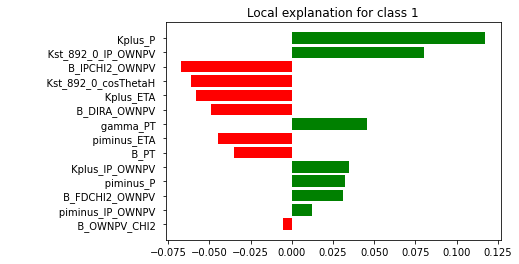

Predicted: 0.0, Actual value: 0.0
EXPLANATION 2


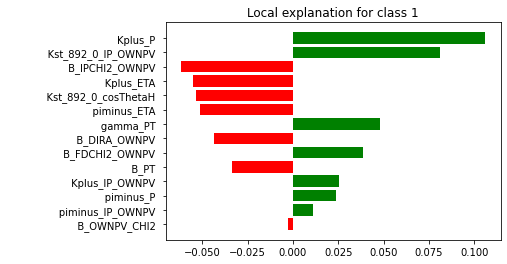

Predicted: 0.0, Actual value: 0.0
EXPLANATION 3


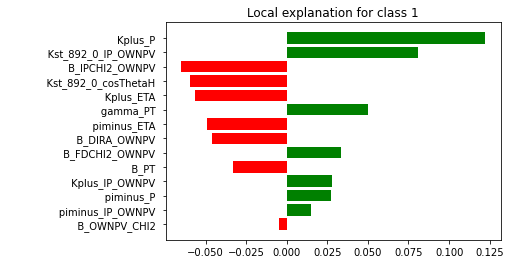

Predicted: 0.0, Actual value: 0.0
EXPLANATION 4


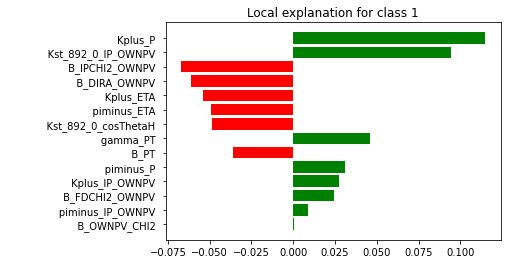

Predicted: 0.0, Actual value: 0.0
EXPLANATION 5


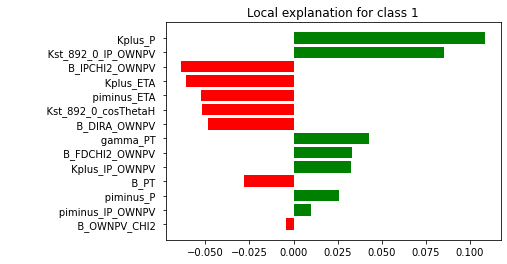

Predicted: 0.0, Actual value: 0.0
EXPLANATION 6


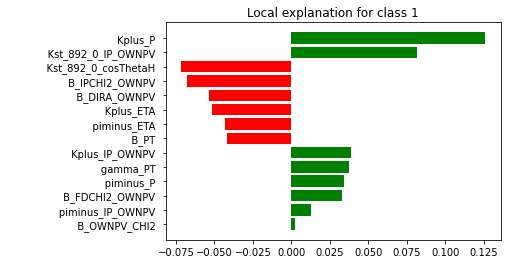

Predicted: 0.0, Actual value: 0.0
EXPLANATION 7


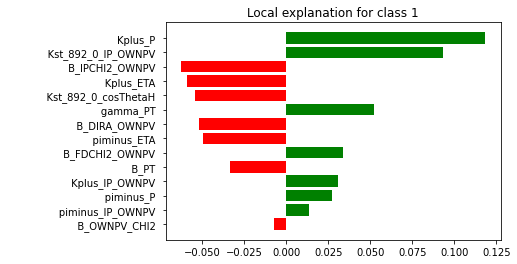

Predicted: 0.0, Actual value: 0.0
EXPLANATION 8


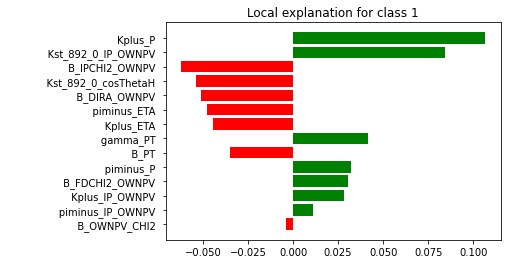

Predicted: 0.0, Actual value: 0.0
EXPLANATION 9


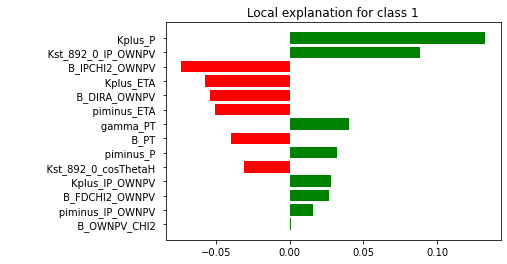

Predicted: 0.0, Actual value: 0.0
EXPLANATION 10


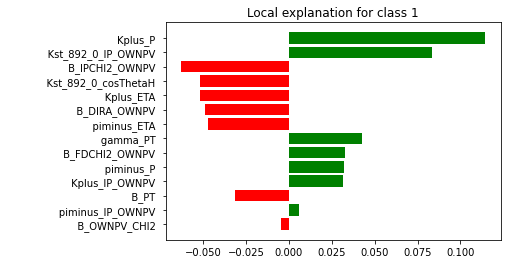

Predicted: 0.0, Actual value: 0.0


In [44]:
#generate explanations
count = 0
for i in y0:
    count += 1
    print("===========================================================")
    print(f"EXPLANATION {count}")
    print("===========================================================")
    exp = explainer.explain_instance(X_test.values[i], xgb_model.predict_proba, num_features=14)
    fig = exp.as_pyplot_figure()
    plt.show()
    print(f"Predicted: {y_pred[i]}, Actual value: {y_test.values[i]}")
    

Explaining the 10 positive signals (y=1)

EXPLANATION 1


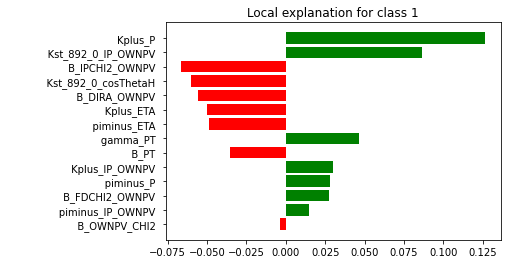

Predicted: 1.0, Actual value: 1.0
EXPLANATION 2


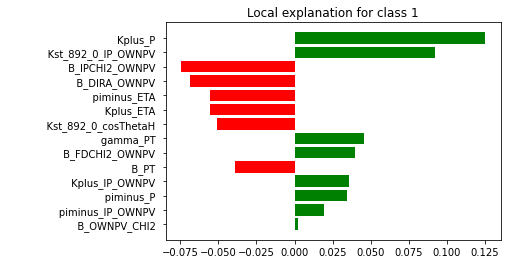

Predicted: 1.0, Actual value: 1.0
EXPLANATION 3


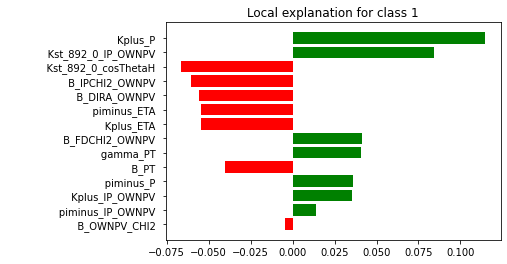

Predicted: 1.0, Actual value: 1.0
EXPLANATION 4


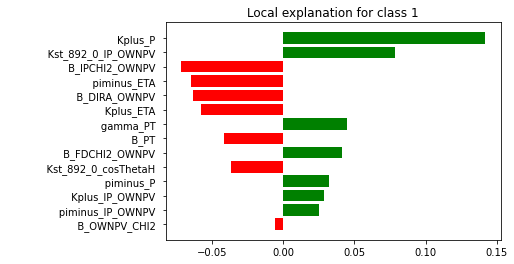

Predicted: 1.0, Actual value: 1.0
EXPLANATION 5


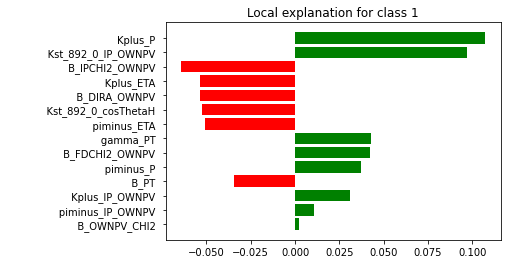

Predicted: 1.0, Actual value: 1.0
EXPLANATION 6


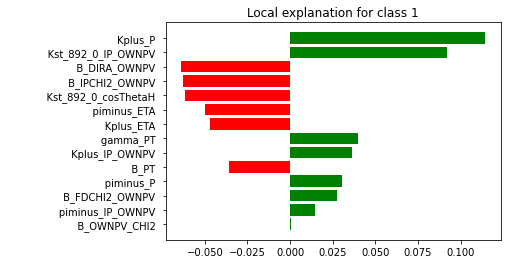

Predicted: 1.0, Actual value: 1.0
EXPLANATION 7


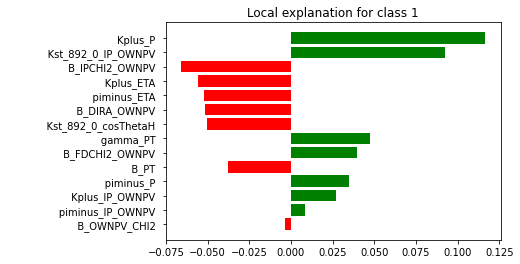

Predicted: 1.0, Actual value: 1.0
EXPLANATION 8


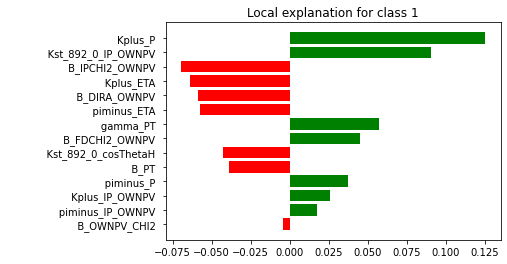

Predicted: 1.0, Actual value: 1.0
EXPLANATION 9


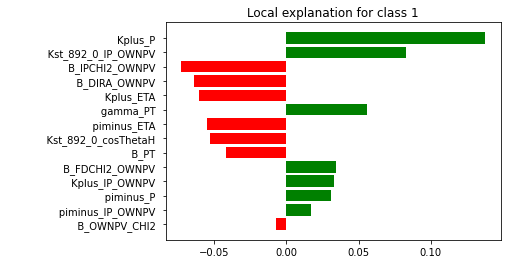

Predicted: 1.0, Actual value: 1.0
EXPLANATION 10


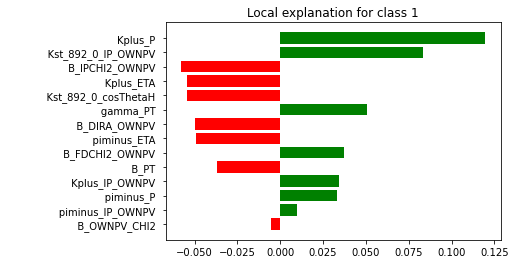

Predicted: 1.0, Actual value: 1.0


In [45]:
#generate explanations
count = 0
for i in y1:
    count += 1
    print("===========================================================")
    print(f"EXPLANATION {count}")
    print("===========================================================")
    exp = explainer.explain_instance(X_test.values[i], xgb_model.predict_proba, num_features=14)
    fig = exp.as_pyplot_figure()
    plt.show()
    print(f"Predicted: {y_pred[i]}, Actual value: {y_test.values[i]}")
    

The most used features are Kplus_P and Kst_892_0_IP_OWNPV, while the least important is B_OWNPV_CHI2.

### Feature engineering

#### Removing the least used feature (B_OWNPV_CHI2)

In [92]:
data_fe = data.iloc[:, :-1].copy()
# remove spaces from column names
data_fe.columns = features
scaled = sc.fit_transform(data_fe.values)
print(scaled.shape)
X_fe = pd.DataFrame(data=scaled, columns=data_fe.columns)


X_fe.drop(['B_OWNPV_CHI2'], axis=1, inplace=True)

print(X_fe.shape)
X_fe.head()

(212662, 14)
(212662, 13)


,B_IPCHI2_OWNPV,B_FDCHI2_OWNPV,B_DIRA_OWNPV,B_PT,Kst_892_0_IP_OWNPV,Kst_892_0_cosThetaH,Kplus_IP_OWNPV,Kplus_P,piminus_IP_OWNPV,piminus_P,gamma_PT,piminus_ETA,Kplus_ETA
0,-0.076019,-0.020581,0.506625,2.457603,-0.010281,-1.635157,-0.000083,1.928913,0.092874,-0.567258,0.808782,-1.001080,-0.923161
1,-1.235330,-0.192592,0.509224,-0.657723,-0.778374,-1.718573,-0.693486,0.495555,-0.968792,-0.734406,-0.702845,0.273690,-0.153645
2,-0.175317,-0.199826,0.352163,-0.380149,-0.841548,0.066418,-0.833509,-0.103088,-0.749528,0.028360,-0.390404,0.544726,-0.085062
3,1.581900,-0.200571,-2.294296,-0.630449,-0.542046,0.772930,-0.627198,-0.995229,-0.421995,-0.747170,-0.925969,-1.647432,-1.832618
4,2.166203,-0.208622,-0.839829,-0.926588,-0.884865,0.904880,-0.879123,-0.932438,-0.807563,0.141575,-0.657284,0.269023,0.218319


In [93]:
# fix random seed for comparisons
# using stratify to have the same proportion of each y value in train and test
X_train, X_test, y_train, y_test = train_test_split(X_fe, y, stratify=y, test_size=.3, random_state=42)

Define model with previous best params, train on new data and get score

In [94]:
# XGBoost
xgb_fe = Pipeline([ # Add a scale_pos_weight to make it balanced
                      ("model", XGBClassifier(scale_pos_weight=(1 - y.mean()), n_jobs=-1))])

In [95]:
xgb_fe.set_params(**gs.best_params_)
xgb_fe.fit(X_train, y_train)

/home/bambusito/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:28:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=10, min_child_weight=10, missing=nan,
                               monotone_constraints='()', n_estimators=25,
                               n_jobs=-1, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=0.665995805550592, subsample=1,
                               tree_method='exact', validate_parameters=1,
                               verbosity=None))])

In [96]:
y_pred = xgb_fe.predict(X_test)
print(accuracy_score(y_test, y_pred))
# XG Boost Classification Report
print(classification_report(y_test, y_pred))

0.7712503330773209
              precision    recall  f1-score   support

         0.0       0.78      0.91      0.84     42490
         1.0       0.73      0.50      0.59     21309

    accuracy                           0.77     63799
   macro avg       0.76      0.70      0.72     63799
weighted avg       0.77      0.77      0.76     63799



In [97]:
xgb_probs = xgb_fe.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, xgb_probs)

0.8467897628790618

This is a bit worse than using the whole table, since the baseline is 0.8472163370122583.

#### Boosting  Kplus_P 

In [99]:
data_fe.head()

0    1.0
1    1.0
2    1.0
3    0.0
4    0.0
Name: signal, dtype: float64

In [114]:
data_fe = data.iloc[:,:-1].copy()
data_fe.columns = features

data_fe["Squared_Kplus_P"] = data_fe["Kplus_P"]**4

scaled = sc.fit_transform(data_fe.values)
print(scaled.shape)
X_fe = pd.DataFrame(data=scaled, columns=data_fe.columns)



print(X_fe.shape)
X_fe.head()

(212662, 15)
(212662, 15)


,B_OWNPV_CHI2,B_IPCHI2_OWNPV,B_FDCHI2_OWNPV,B_DIRA_OWNPV,B_PT,Kst_892_0_IP_OWNPV,Kst_892_0_cosThetaH,Kplus_IP_OWNPV,Kplus_P,piminus_IP_OWNPV,piminus_P,gamma_PT,piminus_ETA,Kplus_ETA,Squared_Kplus_P
0,-0.132425,-0.076019,-0.020581,0.506625,2.457603,-0.010281,-1.635157,-0.000083,1.928913,0.092874,-0.567258,0.808782,-1.001080,-0.923161,1.313107
1,0.215444,-1.235330,-0.192592,0.509224,-0.657723,-0.778374,-1.718573,-0.693486,0.495555,-0.968792,-0.734406,-0.702845,0.273690,-0.153645,-0.167554
2,0.337583,-0.175317,-0.199826,0.352163,-0.380149,-0.841548,0.066418,-0.833509,-0.103088,-0.749528,0.028360,-0.390404,0.544726,-0.085062,-0.317838
3,-1.080441,1.581900,-0.200571,-2.294296,-0.630449,-0.542046,0.772930,-0.627198,-0.995229,-0.421995,-0.747170,-0.925969,-1.647432,-1.832618,-0.366737
4,1.920171,2.166203,-0.208622,-0.839829,-0.926588,-0.884865,0.904880,-0.879123,-0.932438,-0.807563,0.141575,-0.657284,0.269023,0.218319,-0.366164


In [115]:
# fix random seed for comparisons
# using stratify to have the same proportion of each y value in train and test
X_train, X_test, y_train, y_test = train_test_split(X_fe, y, stratify=y, test_size=.3, random_state=42)

Define model with previous best params, train on new data and get score

In [116]:
# XGBoost
xgb_fe = Pipeline([ # Add a scale_pos_weight to make it balanced
                      ("model", XGBClassifier(scale_pos_weight=(1 - y.mean()), n_jobs=-1))])

In [117]:
xgb_fe.set_params(**gs.best_params_)
xgb_fe.fit(X_train, y_train)

/home/bambusito/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:34:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=10, min_child_weight=10, missing=nan,
                               monotone_constraints='()', n_estimators=25,
                               n_jobs=-1, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=0.665995805550592, subsample=1,
                               tree_method='exact', validate_parameters=1,
                               verbosity=None))])

In [118]:
y_pred = xgb_fe.predict(X_test)
print(accuracy_score(y_test, y_pred))
# XG Boost Classification Report
print(classification_report(y_test, y_pred))

0.7708114547249957
              precision    recall  f1-score   support

         0.0       0.78      0.91      0.84     42490
         1.0       0.73      0.50      0.59     21309

    accuracy                           0.77     63799
   macro avg       0.76      0.70      0.72     63799
weighted avg       0.77      0.77      0.76     63799



In [119]:
xgb_probs = xgb_fe.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, xgb_probs)

0.8472163370122583

 The baseline is 0.8472163370122583
 
 Adding squared Kplus_P: 0.8477051447350792 but with scaling: 0.8472163370122583

 
 Adding cubed Kplus_P: 0.8472163370122583 and with scaling: 0.8472163370122583
 
 Adding it to 4th power: 0.8472163370122583 (with scaling)

#### Boosting Kst_892_0_IP_OWNPV